## Detecção de COVID-19 em Imagens de Raio-X

### Definição do Projeto

A ideia geral da aprendizagem por transferência é usar o conhecimento aprendido em tarefas para as quais muitos dados rotulados estão disponíveis em ambientes onde apenas poucos dados rotulados estão disponíveis. Criar dados rotulados é caro, portanto, aproveitar os conjuntos de dados existentes de maneira ideal é fundamental.

Em um modelo de aprendizado de máquina tradicional, o objetivo principal é generalizar para dados invisíveis com base em padrões aprendidos com os dados de 
treinamento. Com a aprendizagem por transferência, você tenta iniciar esse processo de generalização começando a partir de padrões que foram aprendidos para uma tarefa diferente. Essencialmente, em vez de iniciar o processo de aprendizagem a partir de uma folha em branco (geralmente inicializada aleatoriamente), você começa a partir de padrões que foram aprendidos para resolver uma tarefa diferente. A transferência de conhecimento e padrões é possível em uma ampla variedade de domínios.

Neste projeto vamos construir um modelo de IA que ao receber uma imagem será capaz de detectar se há alguma anomalia que indique a presença de COVID. Daremos ênfase ao Transfer Learning e ainda apresentaremos uma nova técnica de tratamento de dados desbalanceados.

**Referências:**

- <a href="https://deepai.org/machine-learning-glossary-and-terms/transfer-learning">Transfer Learning</a>
- <a href="https://openreview.net/pdf?id=ryebG04YvB">ADVERSARIALLY ROBUST TRANSFER LEARNING</a>
- <a href="https://openreview.net/pdf?id=ryeYpJSKwr">META-LEARNING ACQUISITION FUNCTIONS FOR TRANSFER LEARNING IN BAYESIAN OPTIMIZATION</a>

Fonte de Dados:

https://bimcv.cipf.es/bimcv-projects/bimcv-covid19/#1590858128006-9e640421-6711


### Bibliotecas

In [159]:
# Imports
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import sklearn
import tensorflow as tf
from glob import glob
from distutils.file_util import copy_file
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

matplotlib: 3.3.4
sklearn   : 1.0.2
pandas    : 1.3.5
tensorflow: 2.3.1
numpy     : 1.21.1
seaborn   : 0.11.2



In [4]:
# Versão Python usada neste projeto
!python --version

Python 3.7.6


### Preparação dos Dados

In [5]:
# Caminho para as imagens em disco
caminho_imagens_covid = '/media/datasets/IAMED/Cap12/COVID-19_Radiography_Dataset/COVID'

# Caminho para as imagens em disco
caminho_imagens_normal = '/media/datasets/IAMED/Cap12/COVID-19_Radiography_Dataset/Normal'

In [6]:
# Listas
lista_imagens_covid = []
lista_imagens_normal = []

In [7]:
# Lista imagens covid
for root, directories, files in os.walk(caminho_imagens_covid):
    for name in files:
        lista_imagens_covid.append(os.path.join(root, name))

In [8]:
# Lista imagens normal
for root, directories, files in os.walk(caminho_imagens_normal):
    for name in files:
        lista_imagens_normal.append(os.path.join(root, name))

In [9]:
# Shuffle das imagens
random.shuffle(lista_imagens_covid)
random.shuffle(lista_imagens_normal)

In [10]:
# Total de imagens
print("Quantidade de imagens com COVID-19:", len(lista_imagens_covid))
print("Quantidade de imagens Normais:", len(lista_imagens_normal))

Quantidade de imagens com COVID-19: 3616
Quantidade de imagens Normais: 10192


##### COVID19

In [15]:
# Divide os dados em treino e teste
X_treino_covid, X_teste_covid = train_test_split(lista_imagens_covid, test_size = 0.10, random_state = 42)

In [16]:
# Divide os dados em treino e validação
X_treino_covid, X_valid_covid = train_test_split(X_treino_covid, test_size = 0.2, random_state = 42)

In [17]:
# Total de imagens de COVID
print("Quantidade de imagens em treinamento:", len(X_treino_covid))
print("Quantidade de imagens em validação:", len(X_valid_covid))
print("Quantidade de imagens em teste:", len(X_teste_covid))

Quantidade de imagens em treinamento: 2603
Quantidade de imagens em validação: 651
Quantidade de imagens em teste: 362


##### Normais

In [19]:
# Divide os dados em treino e teste com Downsampling nos dados de treinamento para balancear as imagens de ambas as classes
X_treino_normal, X_teste_normal = train_test_split(lista_imagens_normal[0:3616], test_size = 0.10, random_state = 42)

In [20]:
# Divide os dados em treino e validação
X_treino_normal, X_valid_normal = train_test_split(X_treino_normal, test_size = 0.2, random_state = 42)

In [21]:
# Total de imagens de COVID
print("Quantidade de imagens em treinamento:", len(X_treino_normal))
print("Quantidade de imagens em validação:", len(X_valid_normal))
print("Quantidade de imagens em teste:", len(X_teste_normal))

Quantidade de imagens em treinamento: 2603
Quantidade de imagens em validação: 651
Quantidade de imagens em teste: 362


#### Preparação das pastas para receber as imagens separadas por label.

In [22]:
# Pasta raiz
!mkdir ./dados/

In [23]:
# Pastas para os dados de treino
!mkdir ./dados/treino/
!mkdir ./dados/treino/Covid/
!mkdir ./dados/treino/Normal/

# Pastas para os dados de teste
!mkdir ./dados/teste/
!mkdir ./dados/teste/Covid/
!mkdir ./dados/teste/Normal/

# Pastas para os dados de validação
!mkdir ./dados/valid/
!mkdir ./dados/valid/Covid/
!mkdir ./dados/valid/Normal/

#### Movendo as imagens para suas respectivas pastas.

In [24]:
# Pastas para as imagens covid
caminho_covid_treino = './dados/treino/Covid/'
caminho_covid_teste = './dados/teste/Covid/'
caminho_covid_valid = './dados/valid/Covid/'

# Pastas para as imagens normal
caminho_normal_treino = './dados/treino/Normal/'
caminho_normal_teste = './dados/teste/Normal/'
caminho_normal_valid = './dados/valid/Normal/'

In [25]:
# Movendo as imagens covid
for i in range(2603):
    copy_file(lista_imagens_covid[i], caminho_covid_treino)
for i in range(651):
    copy_file(lista_imagens_covid[i], caminho_covid_valid)
for i in range(362):
    copy_file(lista_imagens_covid[i], caminho_covid_teste)

In [26]:
# Movendo as imagens normal
for i in range(2603):
    copy_file(lista_imagens_normal[i], caminho_normal_treino)
for i in range(651):
    copy_file(lista_imagens_normal[i], caminho_normal_valid)     
for i in range(362):
    copy_file(lista_imagens_normal[i], caminho_normal_teste)       

### Dataset Augmentation

In [109]:
# Gerador dados de treino
gen_data_treino = ImageDataGenerator(rescale = 1./255,
                                     zoom_range = 0.3, 
                                     horizontal_flip = True, 
                                     shear_range = 0.2,
                                     rotation_range = 30)

In [113]:
# Gera dados de treino
dados_treino = gen_data_treino.flow_from_directory(directory = './dados/treino',
                                                   class_mode = 'categorical',
                                                   batch_size = 8,
                                                   target_size = (224,224))

Found 5206 images belonging to 2 classes.


In [114]:
# Gerador dados de teste
gen_data_teste = ImageDataGenerator(rescale = 1./255)

In [115]:
# Gera dados de teste
dados_teste = gen_data_teste.flow_from_directory(directory = './dados/teste' , 
                                                 target_size = (224,244), 
                                                 class_mode = 'categorical',
                                                 shuffle = False,
                                                 batch_size = 1)

Found 724 images belonging to 2 classes.


In [116]:
# Gera dados de validação
dados_valid = gen_data_teste.flow_from_directory(directory = './dados/valid' , 
                                                 target_size = (224,224), 
                                                 class_mode = 'categorical',
                                                 shuffle = False,
                                                 batch_size = 8)

Found 1302 images belonging to 2 classes.


In [117]:
# Aqui definimos o número de passos
passos_treino = np.ceil(5206/8)
passos_val = np.ceil(1302/8)

### Modelagem - Transfer Learning

In [128]:
# Importa o modelo base
modelo_base = VGG16(include_top = False, 
                                weights = 'imagenet',
                                input_shape = (224,224,3))

In [129]:
# Sumário do modelo base
modelo_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [130]:
# Adicionamos nossas camadas ao modelo_base

# Cria a sequência de camadas
add_model = Sequential()

# Adiciona primeiro o modelo base
add_model.add(modelo_base)

# Precisamos de uma camada global de Pooling
add_model.add(GlobalAveragePooling2D())

# Dropout para regularização e evitar overfitting
add_model.add(Dropout(0.2))

# 1º Camada densa
add_model.add(Dense(8, activation = 'relu'))
add_model.add(Dropout(0.2))

# Camada de saida com ativação softmax para previsão das probabilidades das classes
add_model.add(Dense(2, activation = 'softmax'))

In [131]:
# Cria o modelo final
modelo_final = add_model

In [132]:
# Sumário do modelo final
modelo_final.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dropout_9 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 14,718,810
Trainable params: 14,718,810
Non-trainable params: 0
__________________________________________

#### Compilação

In [133]:
# Cria o otimizador
otimizador = Adam(lr = 0.000001)

# Compilação do modelo
modelo_final.compile(optimizer = otimizador, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

#### Callbacks

In [134]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='modelos/raiox_model.h5',                                                              
                                                               monitor='val_loss',
                                                               verbose = 1,
                                                               mode='min',
                                                               save_best_only=True)

In [135]:
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                              factor=0.1,
                                              verbose = 1,
                                              patience=15,                                              
                                              mode="min",
                                              min_lr=0.0000001) 

In [136]:
# Lista de callbacks
lista_callbacks = [checkpoint,reduce]

### Treinamento do Modelo

In [137]:
# Treinamento do modelo
history = modelo_final.fit(dados_treino, 
                    steps_per_epoch = passos_treino, 
                    validation_data = dados_valid,
                    validation_steps = passos_val,
                    epochs = 100, 
                    verbose = 1,
                    callbacks = lista_callbacks)

Epoch 1/100
651/651 [==============================] - ETA: 0s - loss: 0.6585 - accuracy: 0.6343
Epoch 00001: val_loss improved from inf to 0.61114, saving model to modelos/raiox_model.h5
651/651 [==============================] - 56s 86ms/step - loss: 0.6585 - accuracy: 0.6343 - val_loss: 0.6111 - val_accuracy: 0.7227
Epoch 2/100
651/651 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7482
Epoch 00002: val_loss improved from 0.61114 to 0.51721, saving model to modelos/raiox_model.h5
651/651 [==============================] - 56s 85ms/step - loss: 0.5577 - accuracy: 0.7482 - val_loss: 0.5172 - val_accuracy: 0.7473
Epoch 3/100
651/651 [==============================] - ETA: 0s - loss: 0.4525 - accuracy: 0.7939
Epoch 00003: val_loss improved from 0.51721 to 0.40767, saving model to modelos/raiox_model.h5
651/651 [==============================] - 56s 86ms/step - loss: 0.4525 - accuracy: 0.7939 - val_loss: 0.4077 - val_accuracy: 0.8195
Epoch 4/100
651/651 [========

651/651 [==============================] - 55s 85ms/step - loss: 0.1756 - accuracy: 0.9403 - val_loss: 0.1091 - val_accuracy: 0.9570
Epoch 28/100
651/651 [==============================] - ETA: 0s - loss: 0.1638 - accuracy: 0.9447
Epoch 00028: val_loss did not improve from 0.10913
651/651 [==============================] - 56s 85ms/step - loss: 0.1638 - accuracy: 0.9447 - val_loss: 0.3058 - val_accuracy: 0.8725
Epoch 29/100
651/651 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9414
Epoch 00029: val_loss improved from 0.10913 to 0.09709, saving model to modelos/raiox_model.h5
651/651 [==============================] - 56s 86ms/step - loss: 0.1734 - accuracy: 0.9414 - val_loss: 0.0971 - val_accuracy: 0.9724
Epoch 30/100
651/651 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.9443
Epoch 00030: val_loss did not improve from 0.09709
651/651 [==============================] - 55s 85ms/step - loss: 0.1579 - accuracy: 0.9443 - val_loss: 0.1187 

Epoch 56/100
651/651 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9645
Epoch 00056: val_loss did not improve from 0.06132
651/651 [==============================] - 55s 85ms/step - loss: 0.1103 - accuracy: 0.9645 - val_loss: 0.0844 - val_accuracy: 0.9654
Epoch 57/100
651/651 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9597
Epoch 00057: val_loss did not improve from 0.06132
651/651 [==============================] - 55s 85ms/step - loss: 0.1179 - accuracy: 0.9597 - val_loss: 0.0632 - val_accuracy: 0.9777
Epoch 58/100
651/651 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9599
Epoch 00058: val_loss did not improve from 0.06132
651/651 [==============================] - 55s 85ms/step - loss: 0.1161 - accuracy: 0.9599 - val_loss: 0.0727 - val_accuracy: 0.9731
Epoch 59/100
651/651 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9624
Epoch 00059: val_loss did not improve from 0.06132
651/6

Epoch 85/100
651/651 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9768
Epoch 00085: val_loss did not improve from 0.04868
651/651 [==============================] - 55s 85ms/step - loss: 0.0713 - accuracy: 0.9768 - val_loss: 0.0569 - val_accuracy: 0.9777
Epoch 86/100
651/651 [==============================] - ETA: 0s - loss: 0.0794 - accuracy: 0.9777
Epoch 00086: val_loss did not improve from 0.04868
651/651 [==============================] - 55s 85ms/step - loss: 0.0794 - accuracy: 0.9777 - val_loss: 0.0570 - val_accuracy: 0.9785
Epoch 87/100
651/651 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9771
Epoch 00087: val_loss improved from 0.04868 to 0.04721, saving model to modelos/raiox_model.h5
651/651 [==============================] - 56s 86ms/step - loss: 0.0719 - accuracy: 0.9771 - val_loss: 0.0472 - val_accuracy: 0.9816
Epoch 88/100
651/651 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9768
Epoch 00088:

### Avaliação do Modelo

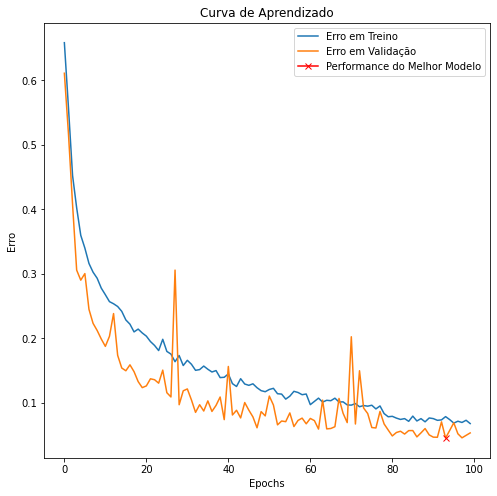

In [138]:
# Resultado do Treinamento
plt.figure(figsize = (8, 8))
plt.title("Curva de Aprendizado")
plt.plot(history.history["loss"], label = "Erro em Treino")
plt.plot(history.history["val_loss"], label = "Erro em Validação")
plt.plot(np.argmin(history.history["val_loss"]), 
         np.min(history.history["val_loss"]), 
         marker ="x", 
         color = "r", 
         label = "Performance do Melhor Modelo")
plt.xlabel("Epochs")
plt.ylabel("Erro")
plt.legend();

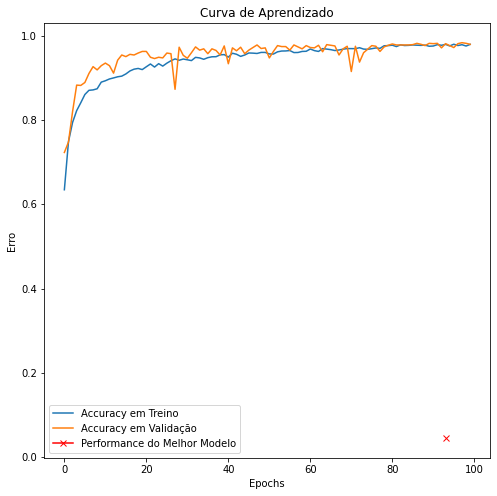

In [139]:
# Resultado do Treinamento
plt.figure(figsize = (8, 8))
plt.title("Curva de Aprendizado")
plt.plot(history.history["accuracy"], label = "Accuracy em Treino")
plt.plot(history.history["val_accuracy"], label = "Accuracy em Validação")
plt.plot(np.argmin(history.history["val_loss"]), 
         np.min(history.history["val_loss"]), 
         marker ="x", 
         color = "r", 
         label = "Performance do Melhor Modelo")
plt.xlabel("Epochs")
plt.ylabel("Erro")
plt.legend();

#### Modelo

In [140]:
# Carregamos o modelo treinado
model =  tf.keras.models.load_model('modelos/raiox_model.h5')

In [141]:
# Extraímos as métricas
val_loss, val_acc = model.evaluate(dados_teste, steps = 724)

724/724 [==============================] - 4s 6ms/step - loss: 0.0552 - accuracy: 0.9724


### Previsões nos dados de teste

In [142]:
# Vamos obter os labels dos dados de teste
labels_teste = dados_teste.classes

In [143]:
# Precisamos dos labels para o plot da matriz de confusão
labels_teste.shape

(724,)

In [144]:
# Imprimimos a etiqueta (label) associada a cada classe
dados_teste.class_indices

{'Covid': 0, 'Normal': 1}

In [145]:
# Fazemos as previsões
previsoes = model.predict(dados_teste, steps = 724, verbose = 1)

724/724 [==============================] - 3s 4ms/step


In [146]:
# Shape das previsões
previsoes.shape

(724, 2)

#### Matriz de confusão

In [147]:
# Função para a Matriz de Confusão
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Matriz de Confusão',
                          cmap = plt.cm.Blues):

    # Se normalize = True, obtemos a matriz de confusão com dados normalizados
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Matriz de Confusão Normalizada")
    else:
        print('Matriz de Confusão Sem Normalização')

    # Mostramos a Matriz de Confusão
    print(cm)

    # Plot
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Plot do texto
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Label Verdadeiro')
    plt.xlabel('Label Previsto')
    plt.tight_layout()

In [148]:
# A função argmax() retorna o índice do valor máximo em uma linha
matriz_conf = confusion_matrix(labels_teste, previsoes.argmax(axis = 1))

In [149]:
# Labels dos dados de teste
dados_teste.class_indices

{'Covid': 0, 'Normal': 1}

In [150]:
# Definimos os rótulos dos labels da classe. Eles precisam corresponder a ordem mostrada acima.
matriz_conf_plot_labels = ['COVID', 'Normal']

Matriz de Confusão Sem Normalização
[[345  17]
 [  3 359]]


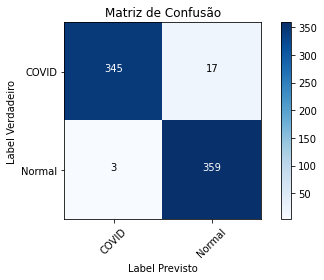

In [151]:
# E então criamos o plot
plot_confusion_matrix(matriz_conf, matriz_conf_plot_labels, title = 'Matriz de Confusão')

#### Relatório de Classificação

In [152]:
# Geramos a sequência na qual o gerador processou as imagens de teste
imagens_teste = dados_teste.filenames

In [153]:
# Obtemos os rótulos verdadeiros
y_true = dados_teste.classes

In [154]:
# Obtemos os rótulos previstos
y_pred = previsoes.argmax(axis=1)

In [155]:
# Gera o relatório de classificação
report = classification_report(y_true, y_pred, target_names = matriz_conf_plot_labels)
print(report)

              precision    recall  f1-score   support

       COVID       0.99      0.95      0.97       362
      Normal       0.95      0.99      0.97       362

    accuracy                           0.97       724
   macro avg       0.97      0.97      0.97       724
weighted avg       0.97      0.97      0.97       724



#### Avaliação com várias métricas de desempenho 

In [160]:
# Avaliação do modelo com 1 batch de dados de teste e 1 estágio do modelo U-Net++
for x_test, y_test in dados_teste:
    break

# Previsão do modelo
y_pred = model.predict(x_test)[0] # Primeira etapa do modelo
        
# Cutoff
y_true = (y_test > 0.5).flatten()
y_pred = (y_pred > 0.5).flatten()

# Relatório de classificação
report = classification_report(y_true, y_pred, output_dict=True)

# Métricas de classificação
Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']
Sensitivity = Recall
Specificity = report['False']['recall']
IOU = (Precision * Recall) / (Precision + Recall - Precision * Recall)
AUC = roc_auc_score(y_true.flatten(), y_pred.flatten())

# Print
print("IOU: {0:.2f}\n".format(IOU))
print("AUC: {0:.2f}\n".format(AUC))
print("Precision: {0:.2f}\n".format(Precision))
print("Recall: {0:.2f}\n".format(Recall))
print("F1-Score: {0:.2f}\n".format(F1_score))
print("Sensitivity: {0:.2f}\n".format(Sensitivity))
print("Specificity: {0:.2f}\n".format(Specificity))
print('-'*55,'\n')
print(classification_report(y_true, y_pred))

IOU: 1.00

AUC: 1.00

Precision: 1.00

Recall: 1.00

F1-Score: 1.00

Sensitivity: 1.00

Specificity: 1.00

------------------------------------------------------- 

              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1
        True       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

